In [2]:
import os
import numpy as np
import pandas as pd
import pydicom
import napari
import matplotlib.pyplot as plt

import SimpleITK as sitk

from dotenv import load_dotenv
load_dotenv();

## Tumor masks

In [2]:
# data_path = os.getenv("MAIN_PATH", "")
data_path = "/media/pedro-lima/HDD/downloads/tcia"

# DICOM_FOLDER = f"{data_path}/MRI_SEG_DICOM/Breast_MRI_086/01-01-1990-NA-BREASTROUTINE-86704/5.000000-ax dyn 1st pass-39884/"
DICOM_FOLDER = f"{data_path}/Duke-Breast-Cancer-MRI/Breast_MRI_052/01-01-1990-NA-BREASTROUTINEDYNAMICS-37889/7.000000-ax dyn 1st pass-37791/"
# DICOM_FOLDER = f"{data_path}/Duke-Breast-Cancer-MRI/Breast_MRI_552/01-01-1990-NA-MRI BREAST BILATERAL W  WO-58725/6.000000-1st ax dyn-40086/"
# DICOM_FOLDER = f"{data_path}/Duke-Breast-Cancer-MRI/Breast_MRI_102/01-01-1990-NA-MRI BREAST BILATERAL WWO-14980/5.000000-ax 3d dyn 1st pass-05549/"

# ANNOTATION_BOX_FILE = f"{data_path}/Supplemental-Data/Annotation_Boxes.xlsx"
ANNOTATION_BOX_FILE = f"{data_path}/Annotation_Boxes.xlsx"

NRRD_FILE = f"{data_path}/nrrd_images/Breast_MRI_052/post_1.nrrd"

### convert DICOM to NRRD

In [3]:
def collect_patient_data(root_dir, max_patients=0):

    collected_paths = []
    patient_count = 0

    for patient_folder in os.listdir(root_dir):
        patient_path = os.path.join(root_dir, patient_folder)

        if not os.path.isdir(patient_path):
            continue

        if patient_count >= max_patients:
            break

        # get the random folder inside the patient folder
        random_folder = next((f for f in os.listdir(patient_path) if os.path.isdir(os.path.join(patient_path, f))), None)
        if not random_folder:
            continue

        random_folder_path = os.path.join(patient_path, random_folder)

        for modality_folder in os.listdir(random_folder_path):
            modality_path = os.path.join(random_folder_path, modality_folder)
            if os.path.isdir(modality_path) and "segment" not in modality_path.lower():
                idx = modality_path.find("Breast_MRI_")
                collected_paths.append(modality_path[idx:])

        patient_count += 1

    return collected_paths

MRI_DICOM_FOLDER = f"{data_path}/MRI_SEG_DICOM/"
max_patients_to_process = 2
valid_paths = collect_patient_data(MRI_DICOM_FOLDER, max_patients=max_patients_to_process)

In [4]:
mapping_paths = {}
for chunk in pd.read_csv("/media/pedro-lima/HDD/downloads/File_Path_Mapping_Tables.csv", chunksize=1_000):
    chunk["original_path_and_filename"] = chunk["original_path_and_filename"].apply(os.path.dirname).str.replace("DICOM_Images/", data_path+"/MRI_NRRD/") + ".nrrd"
    
    chunk["descriptive_path"] = chunk["descriptive_path"].apply(os.path.dirname)
    chunk["descriptive_path"] = chunk["descriptive_path"].str.replace(r'BreastMRI(\d+)', r'Breast_MRI_\1', regex=True)
    chunk["descriptive_path"] = chunk["descriptive_path"].apply(lambda x: x[x.find("Breast_MRI_"):])

    chunk.drop_duplicates(inplace=True)
    mapping_paths.update(chunk.set_index("descriptive_path")["original_path_and_filename"].to_dict())

mapping_paths = {k: v for k, v in mapping_paths.items() if list(mapping_paths.values()).count(v) == 1}

In [5]:
new_dict = {}

for p in valid_paths:
    for m,v in mapping_paths.items():
        if p.split("/")[0] == m.split("/")[0] and p.split("-")[-1] == m.split("-")[-1]:
            new_dict[f"{data_path}/MRI_SEG_DICOM/{p}"] = v

In [6]:
def dicom_to_nrrd(dicom_folder, nrrd_path):
    """load the DICOM images, stack them into a 3D array, and save them as an NRRD file"""
    dicom_reader = sitk.ImageSeriesReader()
    dicom_files = dicom_reader.GetGDCMSeriesFileNames(dicom_folder)
    dicom_reader.SetFileNames(dicom_files)
    image_3d = dicom_reader.Execute()
    
    os.makedirs(os.path.dirname(nrrd_path), exist_ok=True)
    sitk.WriteImage(image_3d, nrrd_path)


In [ ]:
for d_folder, nrrd_file  in new_dict.items():
    dicom_to_nrrd(d_folder, nrrd_file)

In [4]:
### checar se foram criados os arquivos nrrd
def count_files(main_path):
    total_files = 0

    for root, dirs, files in os.walk(main_path):
        # dirs[:] = [d for d in dirs if 'segment' not in d.lower()]
        total_files += len(files)
    
    return total_files

file_count_nrrd = count_files(f"{data_path}/MRI_NRRD/")
print(f"Total files: {file_count_nrrd}")

Total files: 5033


### get 3D bounding boxes from annotation file

In [100]:
image_3d = sitk.ReadImage(NRRD_FILE)

image_array = sitk.GetArrayFromImage(image_3d)
print(f"Image shape (Depth, Height, Width): {image_array.shape}")

origin = image_3d.GetOrigin()
print(f"\nOrigin (x, y, z): {origin} - Physical coordinates of the voxel at index (0, 0, 0)")

direction = image_3d.GetDirection()
print(f"\nDirection (3x3 matrix flattened): {direction} - Orientation of the image axes in physical space")
print("  - X-axis direction:", direction[:3])
print("  - Y-axis direction:", direction[3:6])
print("  - Z-axis direction:", direction[6:])

size = image_3d.GetSize()
print(f"\nSize (Width, Height, Depth): {size} - Number of voxels along each dimension")

spacing = image_3d.GetSpacing()
print(f"\nSpacing (x, y, z): {spacing} - Physical size of each voxel in millimeters")

Image shape (Depth, Height, Width): (128, 448, 448)

Origin (x, y, z): (-166.92173627525, -134.13198276848, -68.743050396442) - Physical coordinates of the voxel at index (0, 0, 0)

Direction (3x3 matrix flattened): (1.0, 2.051034e-10, 0.0, -2.051034e-10, 1.0, 0.0, 0.0, 0.0, 0.9999999999999999) - Orientation of the image axes in physical space
  - X-axis direction: (1.0, 2.051034e-10, 0.0)
  - Y-axis direction: (-2.051034e-10, 1.0, 0.0)
  - Z-axis direction: (0.0, 0.0, 0.9999999999999999)

Size (Width, Height, Depth): (448, 448, 128) - Number of voxels along each dimension

Spacing (x, y, z): (0.75892859697342, 0.75892859697342, 1.3999999761581259) - Physical size of each voxel in millimeters


In [101]:
patient_id = NRRD_FILE.split("/")[-2]
annotation_df = pd.read_excel(ANNOTATION_BOX_FILE)
annotation_dict = annotation_df[annotation_df['Patient ID'] == patient_id].iloc[0].to_dict()
annotation_dict

{'Patient ID': 'Breast_MRI_052',
 'Start Row': 148,
 'End Row': 173,
 'Start Column': 340,
 'End Column': 361,
 'Start Slice': 54,
 'End Slice': 67}

In [ ]:
mapping_paths = {}
for chunk in pd.read_csv(f"{data_path}/File_Path_Mapping_Tables.csv", chunksize=5_000):
    chunk = chunk[chunk['original_path_and_filename'].str.contains('post_1')]
    chunk["original_path_and_filename"] = chunk["original_path_and_filename"].apply(os.path.dirname).str.replace("DICOM_Images/", "").str.replace("/post_1", "")
    
    chunk["descriptive_path"] = chunk["descriptive_path"].apply(os.path.dirname)
    chunk["descriptive_path"] = chunk["descriptive_path"].str.replace(r'BreastMRI(\d+)', r'Breast_MRI_\1', regex=True)
    chunk["descriptive_path"] = chunk["descriptive_path"].apply(lambda x: x[x.find("Breast_MRI_"):])

    chunk.drop_duplicates(inplace=True)
    mapping_paths.update(chunk.set_index("original_path_and_filename")["descriptive_path"].to_dict())

mapping_paths = {k: v for k, v in mapping_paths.items() if list(mapping_paths.values()).count(v) == 1}
# example of mapping paths
dict(list(mapping_paths.items())[:2])

{'Breast_MRI_001': 'Breast_MRI_001/01-01-1990-MRI BREAST BILATERAL W/WO-97538/5.000000-ax dyn 1st pass-59529',
 'Breast_MRI_002': 'Breast_MRI_002/01-01-1990-MRI BREAST BILATERAL W + W/O-51972/601.000000-Ph1/ax 3d dyn-36797'}

In [115]:
def collect_patient_data(root_dir, dict_ids, max_patients=0):
    collected_paths = []
    patient_count = 0

    for patient_folder in os.listdir(root_dir):
        folder_id = dict_ids.get(patient_folder)
        folder_id = folder_id.split("-")[-1]

        patient_path = os.path.join(root_dir, patient_folder)

        if not os.path.isdir(patient_path):
            continue

        if patient_count >= max_patients:
            break

        # get the random subfolder inside the patient folder
        random_folder = next((f for f in os.listdir(patient_path) if os.path.isdir(os.path.join(patient_path, f))), None)
        if not random_folder:
            continue

        random_folder_path = os.path.join(patient_path, random_folder)

        for modality_folder in os.listdir(random_folder_path):
            if folder_id in modality_folder:
                modality_path = os.path.join(random_folder_path, modality_folder)
                if os.path.isdir(modality_path) and "segment" not in modality_path.lower():
                    idx = modality_path.find("Breast_MRI_")
                    collected_paths.append(modality_path[idx:])

        patient_count += 1

    return collected_paths

collect_patient_data(f"{data_path}/Duke-Breast-Cancer-MRI/", mapping_paths, max_patients=3)

['Breast_MRI_144/01-01-1990-NA-BREASTROUTINE CA-63773/7.000000-ax dyn 1st pass-08982',
 'Breast_MRI_414/01-01-1990-NA-MRI BREAST BILATERAL WWO-20423/701.000000-Ph1ax 3d dyn-25824',
 'Breast_MRI_108/01-01-1990-NA-MR BREAST BILAT W AND WO CONT-DR-28461/401.000000-Ph1Ax Vibrant MultiPhase-59216']

In [ ]:
def create_3d_mask_from_dicom(dicom_folder, annotation_dict, output_path):
    """Create a 3D Mask Based on Annotation Boxes. Tumor voxels are set to 1 and other voxels are set to 0"""
    dicom_files = [pydicom.dcmread(os.path.join(dicom_folder, f)) for f in sorted(os.listdir(dicom_folder)) if f.endswith('.dcm')]
    total_slices = len(dicom_files)

    start_slice, end_slice = int(annotation_dict['Start Slice']), int(annotation_dict['End Slice'])
    start_row, end_row = int(annotation_dict['Start Row']), int(annotation_dict['End Row'])
    start_column, end_column = int(annotation_dict['Start Column']), int(annotation_dict['End Column'])
    # print("Annotation BBox:", start_row, end_row, start_column, end_column, start_slice, end_slice)
    
    z_coordinates = [float(dcm.ImagePositionPatient[2]) for dcm in dicom_files]
    ascending_order = z_coordinates[0] < z_coordinates[-1]
    # print(f"Z-coordinates: {z_coordinates[:3]} ... {z_coordinates[-3:]}")
    # print(f"Ascending order detected: {ascending_order}")
    if not ascending_order:
        dicom_files = dicom_files[::-1]
        z_coordinates = z_coordinates[::-1]
        start_slice, end_slice = total_slices - end_slice + 1, total_slices - start_slice + 1
    # print(f"Adjusted slice indices: {start_slice} to {end_slice}")

    image_array = np.stack([dcm.pixel_array for dcm in dicom_files], axis=0)
    mask_array = np.zeros_like(image_array)

    mask_array[start_slice:end_slice, start_row:end_row, start_column:end_column] = 1

    mask_image = sitk.GetImageFromArray(mask_array)
    
    first_dicom = dicom_files[0]
    image_3d = sitk.ReadImage(first_dicom.filename)
    mask_image.SetSpacing(image_3d.GetSpacing())
    mask_image.SetOrigin(image_3d.GetOrigin())
    mask_image.SetDirection(image_3d.GetDirection())

    sitk.WriteImage(mask_image, output_path)

create_3d_mask_from_dicom(DICOM_FOLDER, annotation_dict, f'{data_path}/nrrd_masks/{patient_id}.seg.nrrd')

## Segmentation

### threshold

In [59]:
MAIN_PATH = os.getenv("MAIN_PATH", "")
MASK_FOLDER = os.getenv("MASK_PATH", "")

PATIENT_ID="Breast_MRI_069"
# 052, 590

IMAGE_PATH=f"{MAIN_PATH}/{PATIENT_ID}/post_1.nrrd"
MASK_PATH=f"{MASK_FOLDER}/{PATIENT_ID}.seg.nrrd"

In [41]:
def intensity_distribution(mri_path, segmentation_path):
    mri_image = sitk.ReadImage(mri_path)
    mri_array = sitk.GetArrayFromImage(mri_image)

    segmentation_image = sitk.ReadImage(segmentation_path)
    segmentation_array = sitk.GetArrayFromImage(segmentation_image)

    segmentation_array = (segmentation_array > 0).astype(np.uint8)

    intensities = mri_array[segmentation_array > 0]

    min_intensity = np.min(intensities)
    max_intensity = np.max(intensities)
    mean_intensity = np.mean(intensities)
    std_intensity = np.std(intensities)
    
    print(f"Intensity Statistics within the Segmentation Region:")
    print(f"Minimum Intensity: {min_intensity}")
    print(f"Maximum Intensity: {max_intensity}")
    print(f"Mean Intensity: {mean_intensity:0.4f}")
    print(f"Standard Deviation: {std_intensity:0.4f}")

    plt.figure(figsize=(8, 5))
    plt.hist(intensities, bins=50, color='blue', alpha=0.7)

    percentages = [0.25, 0.5, 0.75]
    for p in percentages:
        value = max_intensity * p
        print(f"{int(p * 100)}% of Max: {value:0.4f}")
        plt.axvline(value, color='orange', linestyle='--', label=f'{int(p * 100)}% of Max' if p > 0 else '0% of Max')

    plt.axvline(mean_intensity, color='green', linestyle='-', label='Mean')
    plt.axvline(mean_intensity + std_intensity, color='red', linestyle='--', label='Mean + 1 STD')
    plt.axvline(mean_intensity - std_intensity, color='red', linestyle='--', label='Mean - 1 STD')

    plt.title("Intensity Distribution within the Segmentation Region")
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()

Intensity Statistics within the Segmentation Region:
Minimum Intensity: 0
Maximum Intensity: 5108
Mean Intensity: 1336.7583
Standard Deviation: 1018.2924
25% of Max: 1277.0000
50% of Max: 2554.0000
75% of Max: 3831.0000


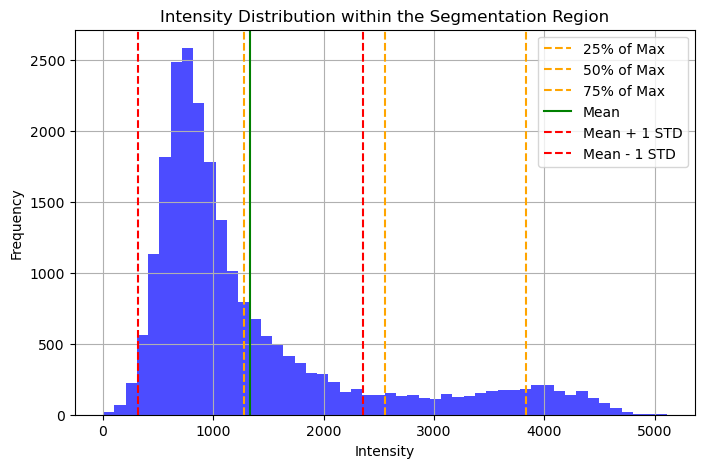

In [57]:
intensity_distribution(IMAGE_PATH, MASK_PATH)

In [56]:
from scipy.ndimage import label, binary_fill_holes, binary_opening

def extract_bounding_box(seg_array):
    coords = np.argwhere(seg_array > 0)
    start = coords.min(axis=0)
    end = coords.max(axis=0) + 1  # include the last index
    return start, end

def apply_threshold(image_array, mask_array, lower_limit, upper_limit):

    intensities = image_array[mask_array > 0]

    min_intensity = np.min(intensities)
    max_intensity = np.max(intensities)
    mean_intensity = np.mean(intensities)
    std_intensity = np.std(intensities)

    lower_threshold = max_intensity * lower_limit # mean_intensity - 0.25 * std_intensity
    upper_threshold = max_intensity * upper_limit # mean_intensity + 0.25 * std_intensity
    print(f"Threshold Range: [{lower_threshold:.2f}, {upper_threshold:.2f}]")
    
    return ((image_array >= lower_threshold) & (image_array <= upper_threshold)).astype(np.uint8)

def refine_thresholded_mask(thresholded_mask):

    filled_mask = binary_fill_holes(thresholded_mask)

    # apply morphological opening (erosion followed by dilation)
    structure = np.ones((1, 1, 1))  # define a 3D structure element
    opened_mask = binary_opening(filled_mask, structure=structure)

    # retain only the largest connected component
    labeled_array, num_features = label(opened_mask)
    if num_features > 0:
        component_sizes = np.bincount(labeled_array.ravel())
        largest_component = np.argmax(component_sizes[1:]) + 1  # exclude background
        refined_mask = (labeled_array == largest_component).astype(np.uint8)
    else:
        refined_mask = np.zeros_like(thresholded_mask, dtype=np.uint8)

    return refined_mask

def visualize_3d_with_napari(image_path, mask_path, mode):

    image = sitk.ReadImage(image_path)
    mask = sitk.ReadImage(mask_path)

    image_array = sitk.GetArrayFromImage(image)
    mask_array = sitk.GetArrayFromImage(mask)

    assert image_array.shape == mask_array.shape, "Image and mask dimensions must match!"

    if mode == "cropped":
        start, end = extract_bounding_box(mask_array)
        image_array = image_array[start[0]:end[0], start[1]:end[1], start[2]:end[2]]
        mask_array = mask_array[start[0]:end[0], start[1]:end[1], start[2]:end[2]]

        thresholded_mask = apply_threshold(image_array, mask_array, 0.5, 0.75)

        # refine thresholded mask
        refined_mask = refine_thresholded_mask(thresholded_mask)
        full_refined_mask = np.zeros_like(image_array, dtype=np.uint8)
        full_refined_mask[mask_array > 0] = refined_mask[mask_array > 0]

        viewer = napari.Viewer(ndisplay=3)  # 3D mode
        viewer.add_image(image_array, name="MRI Image", colormap="gray", rendering="mip")
        viewer.add_labels(mask_array, name="Mask", opacity=0.5)
        viewer.add_labels(thresholded_mask, name="Thresholded Mask", opacity=0.6)
        viewer.add_labels(full_refined_mask, name="Refined Tumor Mask", opacity=0.7)
        # napari.run()
    else:
        viewer = napari.Viewer(ndisplay=3)  # 3D mode
        viewer.add_image(image_array, name="MRI Image", colormap="gray", rendering="mip")
        viewer.add_labels(mask_array, name="Mask", opacity=0.5)
        # napari.run()

In [60]:
visualize_3d_with_napari(IMAGE_PATH, MASK_PATH, "cropped")

Threshold Range: [1200.00, 1800.00]
